To this end, we will be using the Sentiment140 dataset containing data collected from twitter.

# 1. Importing and Discovering the dataset

In [1]:
from time import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Reading the dataset with no columns titles with lation encoding 
df_raw = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding= "ISO-8859-1", header = None)

df_raw.columns = ["Labels", "Time" , "date", "query", "Username" , "text"]

df_raw.head(10) # show first 10 rows of this dataset

,Labels,Time,date,query,Username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [3]:
# Checking the data's output balance
# the label '4' denotes positive and '0' denotes negative sentiment
df_raw['Labels'].value_counts()

0    800000
4    800000
Name: Labels, dtype: int64

In [4]:
#Ommiting every column except for the text and label. as we won't need any of the other information 
df = df_raw[["Labels",'text']]
df.head()

,Labels,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


As our data is huge(16,00,000 rows), working with it on a regular machine is very challenging.For this reason, we will trim our dataframe to 1/4th of its orginal size.
As data output balance is key for a better performing algorithm, we will make sure to maintain the data balance while trimming the dataframe.

In [5]:
# Separating positive and negative rows
df_pos = df[df["Labels"] == 4]
df_neg = df[df["Labels"] == 0]
print(len(df_pos), len(df_neg))

800000 800000


In [6]:
#Only retaining 1/4th of our data from each output group
df_pos = df_pos[:int(len(df_pos)/4)]
df_neg = df_neg[:int(len(df_neg)/4)]
print(len(df_pos), len(df_neg))

200000 200000


In [7]:
#concatinating both positive and negative groups and storing them back into a single dataframe
df = pd.concat([df_pos , df_neg])
len(df)

400000

# 2. Cleaning and Processing the data

### 2.1 Tokenization

In order to feed our text data to a classification model, we first need to tokenize it.
Tokenizer is the process of splitting a single of text into a list of individual words, or tokens.

over here we will use TweetTokenizer; a Twitter-aware tokenizer provided by the nltk library.

In [8]:
start_time = time()
from nltk.tokenize import TweetTokenizer
#the reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest.
#for example, it will transform the word: 'Helooooooooo' to: 'Helooo'
tk = TweetTokenizer(reduce_len=True)
data = []

#separating our features (text) and our labels into two lists to smoothen our work.
X= df['text'].tolist()
Y= df['Labels'].tolist()

#Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
#and its corresponding label
for X, Y in zip(X,Y):
    if Y== 4:
        data.append((tk.tokenize(X) , 1))
        
    else:
        data.append((tk.tokenize(X),0))

#printing the CPU time and the first 5 elements of our 'data' list

print('CPU Time', time() - start_time)

print(data[:5])
        

CPU Time 46.852901220321655
[(['I', 'LOVE', '@Health4UandPets', 'u', 'guys', 'r', 'the', 'best', '!', '!'], 1), (['im', 'meeting', 'up', 'with', 'one', 'of', 'my', 'besties', 'tonight', '!', 'Cant', 'wait', '!', '!', '-', 'GIRL', 'TALK', '!', '!'], 1), (['@DaRealSunisaKim', 'Thanks', 'for', 'the', 'Twitter', 'add', ',', 'Sunisa', '!', 'I', 'got', 'to', 'meet', 'you', 'once', 'at', 'a', 'HIN', 'show', 'here', 'in', 'the', 'DC', 'area', 'and', 'you', 'were', 'a', 'sweetheart', '.'], 1), (['Being', 'sick', 'can', 'be', 'really', 'cheap', 'when', 'it', 'hurts', 'too', 'much', 'to', 'eat', 'real', 'food', 'Plus', ',', 'your', 'friends', 'make', 'you', 'soup'], 1), (['@LovesBrooklyn2', 'he', 'has', 'that', 'effect', 'on', 'everyone'], 1)]


# 2.2 Lemmatization
### Acoording to the Cambridge English Dictionary, Lemmatization is the process of reducing the different forms of a word to one single form, for example reducing "builds" , "building" or "built" to the lemma "build". This will greatly help our classifier by treating all variants of a given word as being references to the original lemma word.
### In this example, we will use nltk's WordNetLemmatizer to accomplish this task. This lemmatizer however takes as input two arguments: a list of tokens to be lemmatized as well as their corresponding part of speech. The most common parts of speech in english are nouns and verbs. In order to extract each token's part of speech, we will utilize nltk's post_tag function, that takes an input a list of tokens, and returns a list of tuples, where each tuple is composed of a token and its corresponding position tag. Various position tags can be outputted from the pos_tag function, however the most notable ones are:

    NNP: Noun, proper, singular
    NN: Noun, common, singular or mass.
    VBG: Verb, gerund or present participle.
    VBN: Verb, past participle.

A full list of position tags can be found at: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [9]:
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('averaged_perceptron_tagger')
# Previewing the pos_tag() output
print(pos_tag(data[0][0]))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/srv_sh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('I', 'PRP'), ('LOVE', 'VBP'), ('@Health4UandPets', 'NNS'), ('u', 'JJ'), ('guys', 'NNS'), ('r', 'VBP'), ('the', 'DT'), ('best', 'JJS'), ('!', '.'), ('!', '.')]


In [10]:
nltk.download('wordnet')
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word , tag in pos_tag(tokens):
        #First , we will convert the pos_tag output tags to tag format that the WordNetLemmatizer() can interpret
        #In general, If a tag starts with NN, the word is a noun and if it starts with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos ='a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence
    
    
#previewing the WordNetLemmatizer() output
print(data[0][0])
print(lemmatize_sentence(data[0][0]))



    

[nltk_data] Downloading package wordnet to /home/srv_sh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['I', 'LOVE', '@Health4UandPets', 'u', 'guys', 'r', 'the', 'best', '!', '!']
['I', 'LOVE', '@Health4UandPets', 'u', 'guy', 'r', 'the', 'best', '!', '!']


# Cleaning the Data

In [11]:
import re , string
nltk.download('stopwords')
#Stopwords are frequently-used words (such as "the, "a","an","in") that do not hold any meaning useful to extract entiment.
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custome function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words. Including many minimally present case would negatively impact the performance.
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return "are"
    if token == 'some1':
        return "someone"
    if token == 'yrs':
        return 'years'
    if token == "mins":
        return "minutes"
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token =='2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forgot'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25' :
        return ' '
    return token


#This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):
    cleaned_tokens = []
    for token , tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        #Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","",token)
        
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        
        cleaned_token = cleaned(token.lower())
        
        #Eliminating the token if its length is less than 3 , if it is a punctuation or if it is a stopword
        
        if cleaned_token not in string.punctuation and len(cleaned_token)>2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
    return cleaned_tokens

#previewing the remove_noise() output
print(data[0][0])
print(remove_noise(data[0][0]))           
        

['I', 'LOVE', '@Health4UandPets', 'u', 'guys', 'r', 'the', 'best', '!', '!']
['love', 'guy', 'best']


[nltk_data] Downloading package stopwords to /home/srv_sh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
start_time = time()
# As the naive Bayesian classifier accepts inputs in a dict-like structure,
#we have to define a function that transforms our data into the required input structure
def list_to_dict(cleaned_tokens):
    return dict([token , True] for token in cleaned_tokens)

cleaned_tokens_list = []

#Removing noise from all the data
for tokens , label in data:
    cleaned_tokens_list.append((remove_noise(tokens),label))

print("Removed Noise, Cpu Time:", time()-start_time)
start_time = time()

final_data = []

#Transforming the data to fit the input stucture of the Naive Baysian classifier
for tokens , label in cleaned_tokens_list:
    final_data.append((list_to_dict(tokens),label))
print("Data prepared for model , CPU time:", time()-start_time)

final_data[:5]
    

Removed Noise, Cpu Time: 410.7832896709442
Data prepared for model , CPU time: 1.0416970252990723


[({'love': True, 'guy': True, 'best': True}, 1),
 ({'meet': True,
   'one': True,
   'besties': True,
   'tonight': True,
   'cant': True,
   'wait': True,
   'girl': True,
   'talk': True},
  1),
 ({'thanks': True,
   'twitter': True,
   'add': True,
   'sunisa': True,
   'get': True,
   'meet': True,
   'hin': True,
   'show': True,
   'area': True,
   'sweetheart': True},
  1),
 ({'sick': True,
   'really': True,
   'cheap': True,
   'hurt': True,
   'much': True,
   'eat': True,
   'real': True,
   'food': True,
   'plus': True,
   'friend': True,
   'make': True,
   'soup': True},
  1),
 ({'effect': True, 'everyone': True}, 1)]

# 3. Visualizing the Data

WordClouds are one of the best visualizations for words frequencies in text documents.
Essentially, what it does is that it produces an image with frequently-appearing words in the text document, where the most frequent words are showcased with bigger font sizes, and less frequent words with smaller font sizes.

positive words


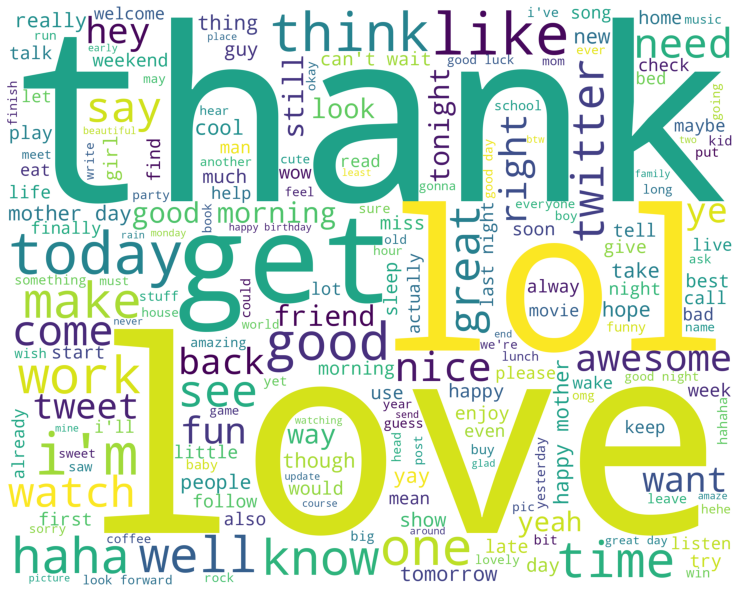

negative words


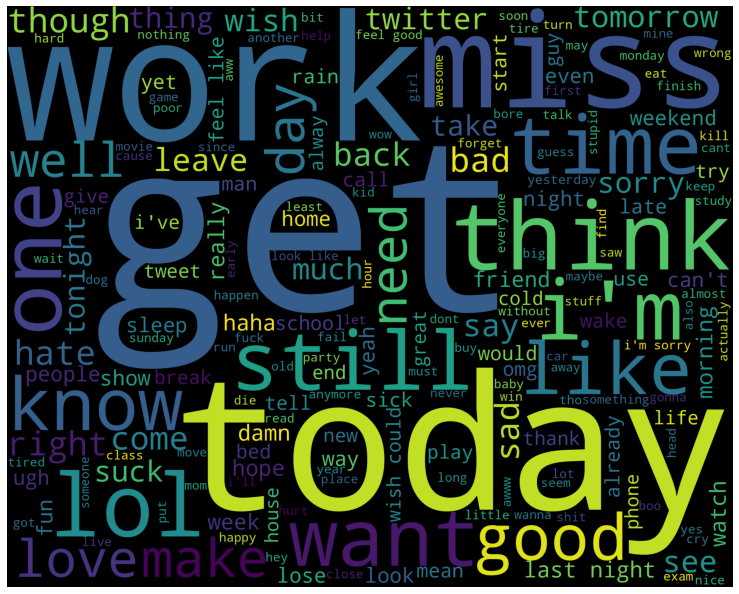

In [13]:
#!pip install wordcloud
from wordcloud import WordCloud , STOPWORDS

start_time = time()

positive_words =[]
negative_words =[]

#separating out positive and negative words (i.e., words appearing in negative and positive tweets)
#in order to visualize each set of words independently

for i in range(len(cleaned_tokens_list)):
    if cleaned_tokens_list[i][1] == 1:
        positive_words.extend(cleaned_tokens_list[i][0])
    else:
        negative_words.extend(cleaned_tokens_list[i][0])
        
#Defining our word cloud drawing function
def word_cloud_draw(data, color = 'black'):
    wordcloud = WordCloud(stopwords = STOP_WORDS,
                         background_color = color,
                         width = 2500,
                         height = 2000).generate(' '.join(data))
    plt.figure(1, figsize= (13,13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("positive words")
word_cloud_draw(positive_words, 'white')
print("negative words")
word_cloud_draw(negative_words , "black")

Those words clouds are beautiful 
it's quite interesting to observe the (higher) occurence of |"love"| , |"lol"| and |"thank"| in thr positive tweets, and of |"work"| and |"miss"| in the negative tweets. However, and in my opinion, the most compelling information observed in those images is without a doubt the huge occurence of the word today in the negative

I personally interpret this information as follows: Bad news travel faster than good news. Peaple tend to talk and share bad news mush more frequently and much more quickly than good news.

# Naive Bayesian Model 

Now that our data is somewhat clean, we can use it to build our classification model. One of the most commonly used classification models in Natural Language Processing (NLP) is Naive Bayesian.
Naive Bayesian classifier are a collecetion of classification algorithm based on Bayes' Theorem.it is not a single algorithm but rather a family of algorithms where all of them make the following naive assumptions:

    All features are independent from each other.
    Every feature contributes equally to the output.

In our case, these two assumption can be interpreted as:

    Each word is independent from the other words, no relation between any two words of a given sentence.
    Each word contributes equally, throughout all sentences, to the decision of our model, regardless of its    relative position in the sentence.
Example: "This is bad" / "This is very bad" or "Such a kind person" / "This kind of chocolate is disgusting" , in both cases the Naive Bayesian classifier would give the same importance for the words 'bad' and 'kind', albeit them having a stronger meaning and different meaning respectively in first and second sentences.

nevertheless, Naive Bayesian are widely used in NLP and they often outpur great results.

The Bayes' Theorem describes the probabily of an event A, based on prior knowlwdge of conditions B that might be related to the event: P(A∣B)=P(B∣A)P(A)/P(B).
In our case, this can be intuitively interpreted as the probability of a tweet being positive, based on prior knowledge of the words inside the input text. In a nutshell, this probability is the probability of the first word occuring in a positibve tweet, times, the probability of second word occuring in a positive tweet,...., time, the probability of a tweet being positive. this can be mathematically written as:
P(A∣B)∝P(B1∣A)×P(B2∣A)×⋅⋅⋅×P(Bn∣A)×P(A)
More details can be found at: https://www.geeksforgeeks.org/naive-bayes-classifiers/


# Splitting the data

First, we need to split our data into two sets: Training and Testing sets.
1. Train Data is data used in order to build and train our classification model.
2. Test Data is data, that our classifier model has never seen before, used in order to assert the accuracy and test our classification model.

In [14]:
#as our data is currently ordered by label, we have to shuffle it before splitting it.
#.Random(140) randomizes our data with seed =140. This guarantees the same suffling for every execution of our code.
# Feel free to alter this value or even omit it to have different outputs for each code execution 
random.Random(140).shuffle(final_data)
#Here we decided to split our data as 90% train data and 10% test data
#Once again, feel free to alter this number and test the model accuracy
trim_index = int(len(final_data)* 0.9)

train_data = final_data[:trim_index]
test_data = final_data[trim_index:]

# 4.2. Training the model

Now it's time to train our model on our training data.
in this notebook, we will utilize nltk's NaiveBayesClassifier.

In [18]:
start_time = time()

from nltk import classify
from nltk import NaiveBayesClassifier

classifier = NaiveBayesClassifier.train(train_data)

#output the model accuracy on the train and test data 

print('Accuracy on the train data:', classify.accuracy(classifier, train_data))
print('Accuracy on the test data:', classify.accuracy(classifier, test_data))

#output the words that provide the most information about the sentiment of a tweet.
# These are words that are heavily present in one sentiment group and very rarely present in the other group
print(classifier.show_most_informative_features(20))
print('\n CPU Time,', time() - start_time)

Accuracy on the train data: 0.8106944444444445
Accuracy on the test data: 0.755575
Most Informative Features
               depressed = True                0 : 1      =     49.0 : 1.0
               toothache = True                0 : 1      =     45.0 : 1.0
                    roni = True                0 : 1      =     34.3 : 1.0
                 unhappy = True                0 : 1      =     31.4 : 1.0
                   strep = True                0 : 1      =     31.0 : 1.0
                  asthma = True                0 : 1      =     26.3 : 1.0
                 unloved = True                0 : 1      =     25.0 : 1.0
                  #movie = True                1 : 0      =     23.0 : 1.0
                  gutted = True                0 : 1      =     22.3 : 1.0
                   hates = True                0 : 1      =     21.9 : 1.0
               heartburn = True                0 : 1      =     21.7 : 1.0
                     bom = True                1 : 0      =     21

wow, a 75.5% accuracy on the test set training a very Naive( :) ) algorithm and in just 34 seconds!

Taking a look at 20 most informative fetures of the model, we can notice the high valume of negative to positive (0:1) informative features. This is very interesting as it means that negative tweets have a much more concentreted and limited vocabulary when compared to positive tweets.



In [23]:
custom_tweet = " I ordered just once from TerribleCo they acrewed up, never used the app again"
print(tk.tokenize(custom_tweet))
custom_tokens = remove_noise(tk.tokenize(custom_tweet))
print(custom_tokens)
print(classifier.classify(dict([token,True] for token in custom_tokens)))


['I', 'ordered', 'just', 'once', 'from', 'TerribleCo', 'they', 'acrewed', 'up', ',', 'never', 'used', 'the', 'app', 'again']
['order', 'terribleco', 'acrewed', 'never', 'use', 'app']
0


In [24]:
custom_tweet = "I loved the show today! It was amazing"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))
print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


In [25]:
custom_tweet = "No idea"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))
print(classifier.classify(dict([token, True] for token in custom_tokens)))

1
